In [15]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [16]:
train_csv_path = "train/train_metadata.csv"
train_image_dir = "train/"

test_csv_path = "test/test_metadata.csv"
test_image_dir = "test/"
output_csv_path = "test/predictions_svm.csv"

train_df = pd.read_csv(train_csv_path)
image_paths = train_df["image_path"].values
labels = train_df["ClassId"].values


In [17]:
train_data = []

for img_file in image_paths:
    try:
        img_path = os.path.join(train_image_dir, img_file)
        image = Image.open(img_path).resize((30, 30)).convert("RGB")
        image_array = np.array(image).reshape(-1) / 255.0
        train_data.append(image_array)
    except Exception as e:
        print(f"Error loading image {img_file}: {e}")
        train_data.append(np.zeros((30 * 30 * 3,)))


In [18]:
X = np.array(train_data)
y = np.array(labels)


In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize with StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [20]:
svm_model = SVC(kernel='linear', C=1.0, verbose=True)
svm_model.fit(X_train_scaled, y_train)


[LibSVM]..*.*
optimization finished, #iter = 1027
obj = -0.037419, rho = 1.332736
nSV = 67, nBSV = 0
.*.*
optimization finished, #iter = 640
obj = -0.026070, rho = 1.213210
nSV = 57, nBSV = 0
.*
optimization finished, #iter = 351
obj = -0.017175, rho = 1.144527
nSV = 37, nBSV = 0
.*..*
optimization finished, #iter = 809
obj = -0.025345, rho = 1.151135
nSV = 47, nBSV = 0
.*
optimization finished, #iter = 379
obj = -0.020894, rho = 1.105724
nSV = 35, nBSV = 0
*
optimization finished, #iter = 50
obj = -0.003438, rho = 0.062725
nSV = 11, nBSV = 0
.*.*
optimization finished, #iter = 449
obj = -0.016676, rho = 0.877662
nSV = 34, nBSV = 0
*.*
optimization finished, #iter = 239
obj = -0.009838, rho = 0.712508
nSV = 29, nBSV = 0
..*.*
optimization finished, #iter = 723
obj = -0.013571, rho = 0.743895
nSV = 44, nBSV = 0
.*
optimization finished, #iter = 394
obj = -0.010870, rho = 0.833189
nSV = 24, nBSV = 0
.*
optimization finished, #iter = 254
obj = -0.008118, rho = 0.674302
nSV = 24, nBSV = 0


SVC(kernel='linear', verbose=True)

In [21]:
# Evaluate on validation set
val_preds = svm_model.predict(X_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, val_preds))


Validation Accuracy: 0.8324225865209471


<Figure size 1200x1200 with 0 Axes>

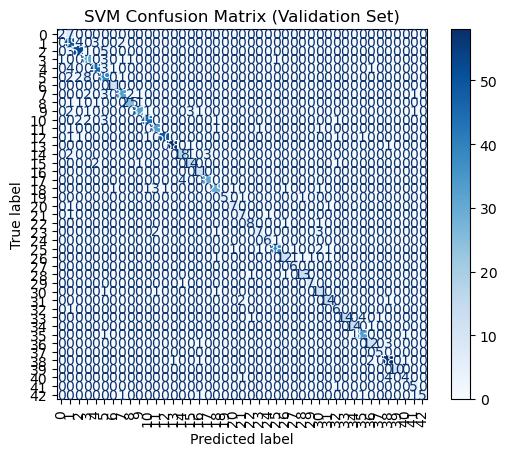

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_val, val_preds)

plt.figure(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title("SVM Confusion Matrix (Validation Set)")
plt.show()


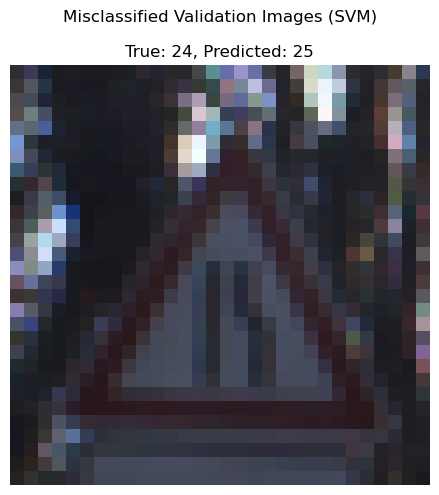

In [23]:
# Find misclassified indices
misclassified_indices = np.where(y_val != val_preds)[0]

plt.figure(figsize=(10, 5))

for i, idx in enumerate(misclassified_indices[:1]):
    original_image_array = X_val[idx] * 255.0  # Reverse normalization
    original_image = original_image_array.reshape((30, 30, 3)).astype(np.uint8)
    
    plt.subplot(1, 1, i + 1)
    plt.imshow(original_image)
    plt.title(f"True: {y_val[idx]}, Predicted: {val_preds[idx]}")
    plt.axis('off')

plt.suptitle("Misclassified Validation Images (SVM)")
plt.tight_layout()
plt.show()


In [24]:
test_df = pd.read_csv(test_csv_path)
test_image_paths = test_df["image_path"].values
test_ids = test_df["id"].values


In [25]:
test_data = []

for img_file in test_image_paths:
    try:
        img_path = os.path.join(test_image_dir, img_file)
        image = Image.open(img_path).resize((30, 30)).convert("RGB")
        image_array = np.array(image).reshape(-1) / 255.0
        test_data.append(image_array)
    except Exception as e:
        print(f"Error loading test image {img_file}: {e}")
        test_data.append(np.zeros((30 * 30 * 3,)))

X_test = np.array(test_data)
X_test_scaled = scaler.transform(X_test)


In [26]:
# Predict and save results
test_preds = svm_model.predict(X_test_scaled)

predictions_df = pd.DataFrame({
    "id": test_ids,
    "ClassId": test_preds
})

predictions_df.to_csv(output_csv_path, index=False)
print(f"Predictions saved to {output_csv_path}")

Predictions saved to test/predictions_svm.csv
